In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import svm 
import os

In [38]:
# Change working directory if needed
if not os.path.exists('data'):
    current_path = os.getcwd()
    root_path = os.path.abspath(os.path.join(current_path, '..'))
    os.chdir(root_path)
    print(f'Changed working directory to: {os.getcwd()}')

# Loading data
group_4_daily = pd.read_parquet('data/02_processed/parquet/group_4_daily.parquet')
weather_daily = pd.read_csv('data/00_raw/weather_daily_darksky.csv')
uk_bank_holidays = pd.read_csv('data/00_raw/uk_bank_holidays.csv')

# Preprocessing data
group_4_daily['Date'] = pd.to_datetime(group_4_daily['Date'])
weather_daily['time'] = pd.to_datetime(weather_daily['time'])
uk_bank_holidays['Bank holidays'] = pd.to_datetime(uk_bank_holidays['Bank holidays'], format='mixed')

# Convert both to date only (no time)
group_4_daily['Date_only'] = group_4_daily['Date'].dt.date
weather_daily['Date_only'] = weather_daily['time'].dt.date

# Select relevant columns
group_4_daily_sel = group_4_daily[['Acorn', 'Date', 'Date_only', 'Conso_kWh']]
weather_daily_sel = weather_daily[['Date_only', 'dewPoint', 'windSpeed', 'temperatureMax', 'temperatureMin']]

# Merge on 'Date_only'
qdf = pd.merge(group_4_daily_sel, weather_daily_sel, on='Date_only', how='left')

# Add bank holiday information
# merged_df['is_bank_holiday'] = merged_df['Date_only'].isin(uk_bank_holidays['Bank holidays'].dt.date)

# Create separate datasets for each Acorn group
qdfC = qdf[qdf['Acorn'] == 'ACORN-C'].copy()
qdfF = qdf[qdf['Acorn'] == 'ACORN-F'].copy()
qdfP = qdf[qdf['Acorn'] == 'ACORN-P'].copy()

# Remove 'Acorn' column and keep only 'Date' (drop 'Date_only') for the three dataframes
for df in [qdfC, qdfF, qdfP]:
    if 'Acorn' in df.columns:
        df.drop(columns=['Acorn'], inplace=True)
    if 'Date_only' in df.columns:
        df.drop(columns=['Date_only'], inplace=True)


=== Statistiques pour ACORN-C ===
Index(['Date', 'Conso_kWh', 'dewPoint', 'windSpeed', 'temperatureMax',
       'temperatureMin'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, 0 to 561
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            562 non-null    datetime64[ns]
 1   Conso_kWh       562 non-null    float64       
 2   dewPoint        560 non-null    float64       
 3   windSpeed       560 non-null    float64       
 4   temperatureMax  560 non-null    float64       
 5   temperatureMin  560 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 30.7 KB
                                Date   Conso_kWh    dewPoint   windSpeed  \
count                            562  562.000000  560.000000  560.000000   
mean   2013-04-06 23:42:03.843416576   11.834227    7.227464    3.502911   
min              2012-07-01 00:00:00    8.9

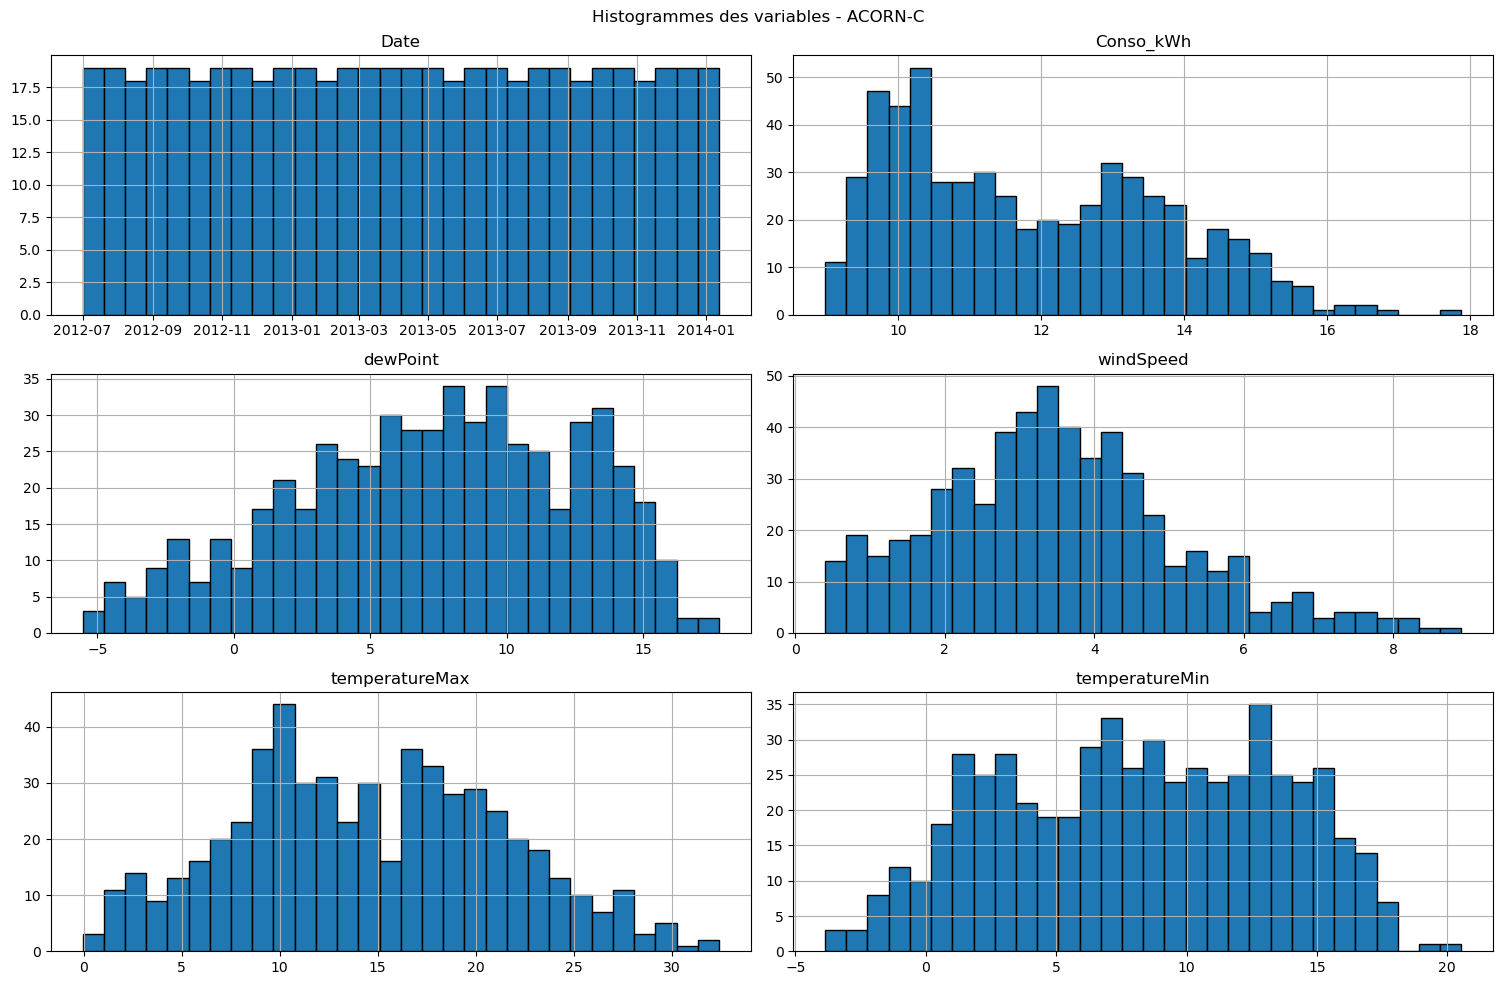

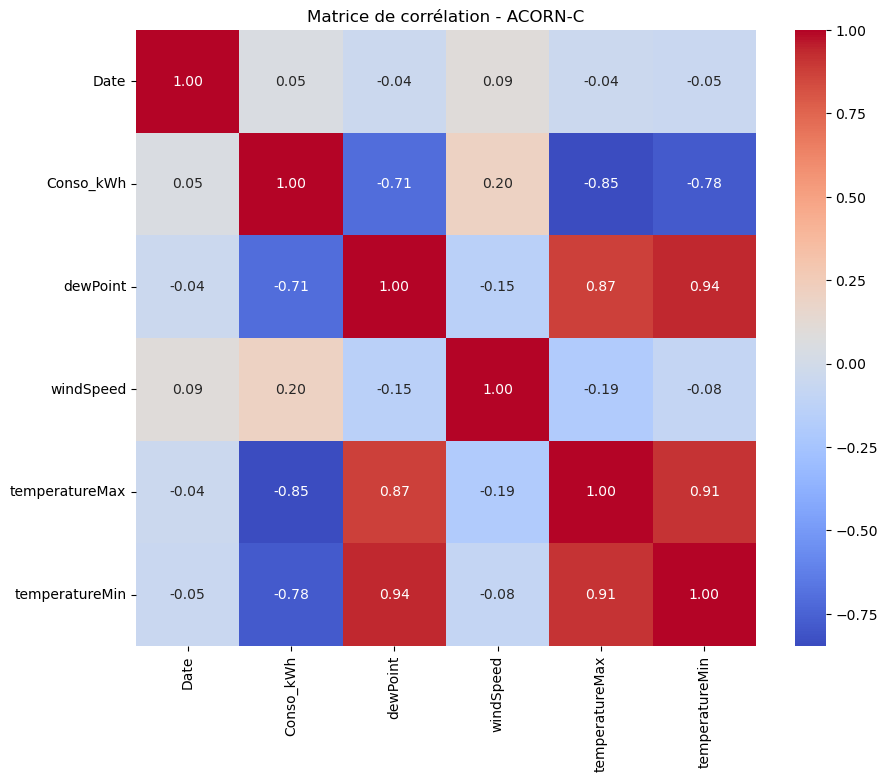


=== Statistiques pour ACORN-F ===
Index(['Date', 'Conso_kWh', 'dewPoint', 'windSpeed', 'temperatureMax',
       'temperatureMin'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, 562 to 1123
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            562 non-null    datetime64[ns]
 1   Conso_kWh       562 non-null    float64       
 2   dewPoint        560 non-null    float64       
 3   windSpeed       560 non-null    float64       
 4   temperatureMax  560 non-null    float64       
 5   temperatureMin  560 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 30.7 KB
                                Date   Conso_kWh    dewPoint   windSpeed  \
count                            562  562.000000  560.000000  560.000000   
mean   2013-04-06 23:42:03.843416576    9.209695    7.227464    3.502911   
min              2012-07-01 00:00:00    

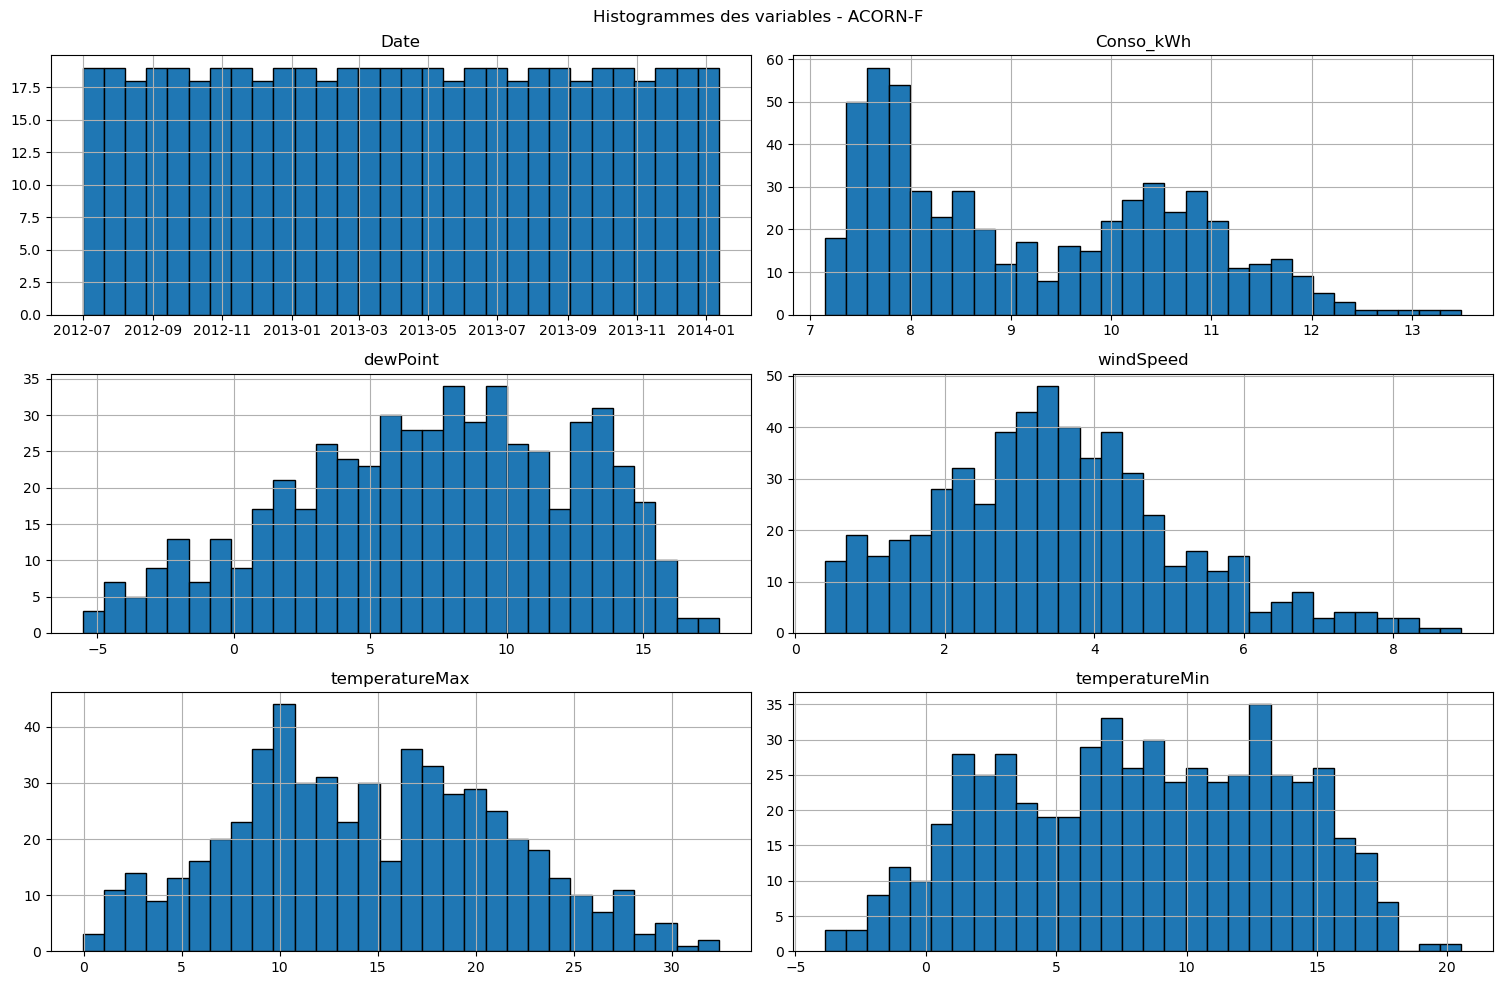

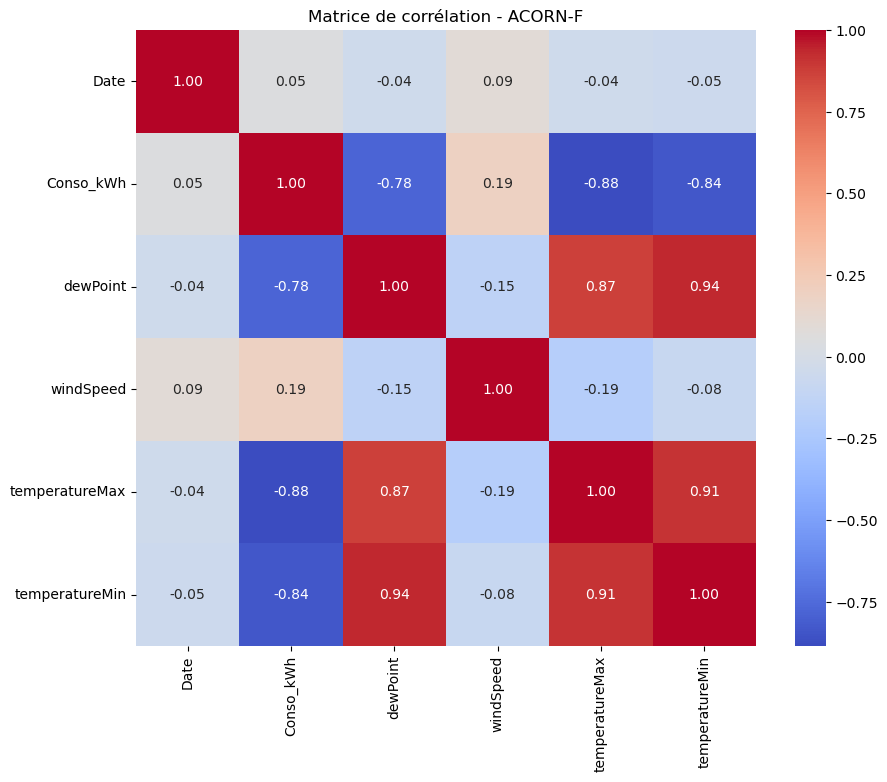


=== Statistiques pour ACORN-P ===
Index(['Date', 'Conso_kWh', 'dewPoint', 'windSpeed', 'temperatureMax',
       'temperatureMin'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, 1124 to 1685
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            562 non-null    datetime64[ns]
 1   Conso_kWh       562 non-null    float64       
 2   dewPoint        560 non-null    float64       
 3   windSpeed       560 non-null    float64       
 4   temperatureMax  560 non-null    float64       
 5   temperatureMin  560 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 30.7 KB
                                Date   Conso_kWh    dewPoint   windSpeed  \
count                            562  562.000000  560.000000  560.000000   
mean   2013-04-06 23:42:03.843416576    6.439547    7.227464    3.502911   
min              2012-07-01 00:00:00   

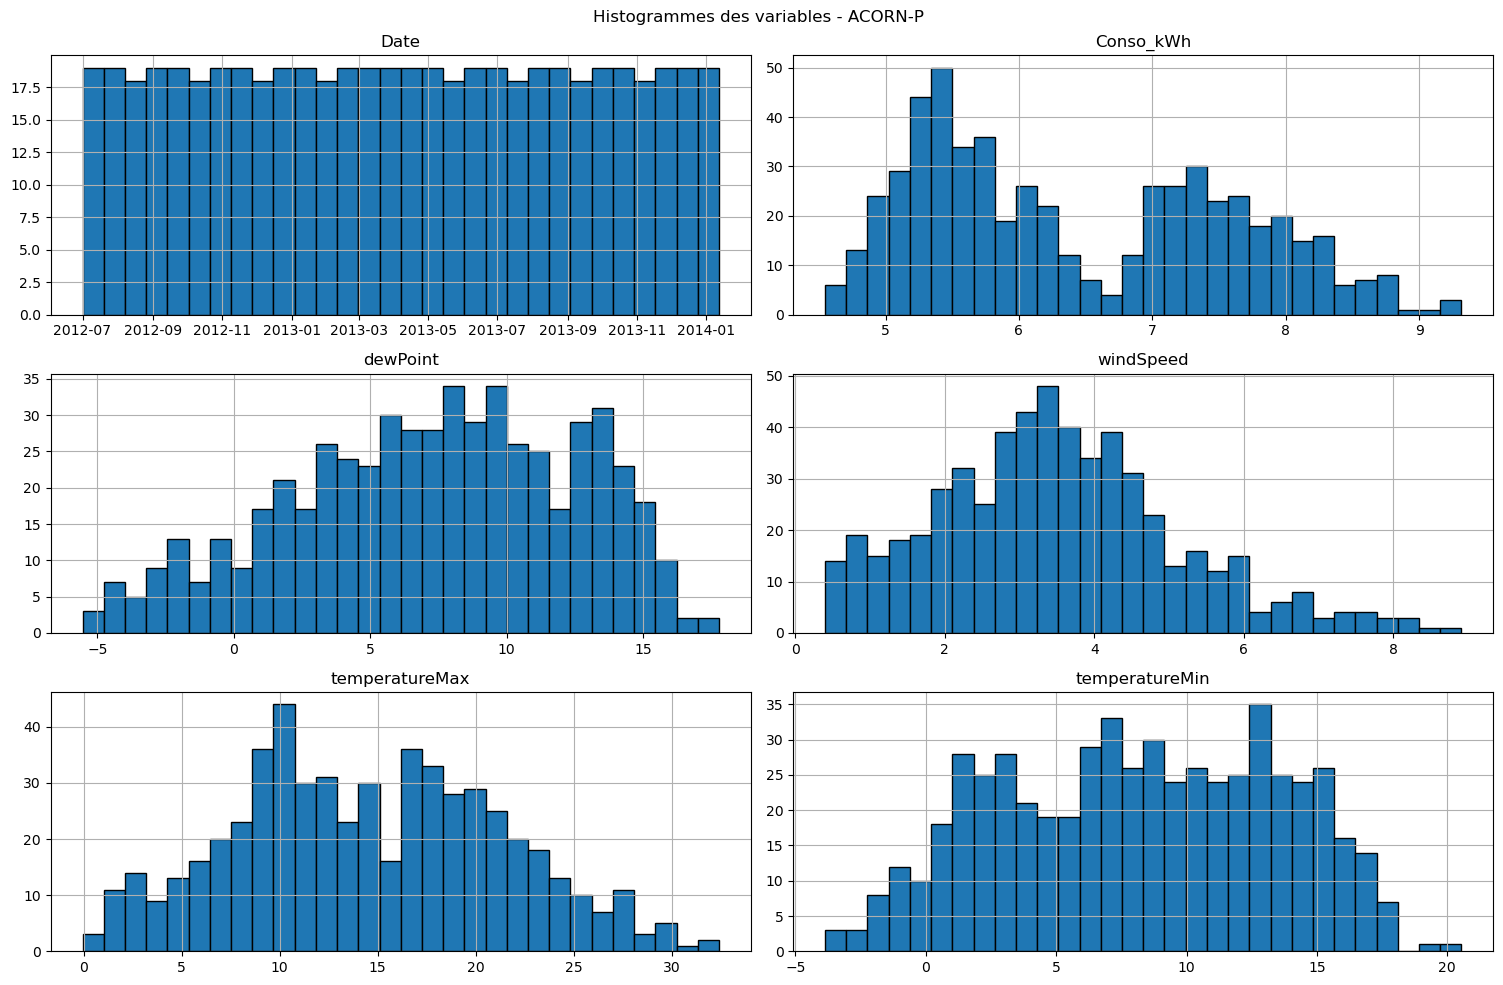

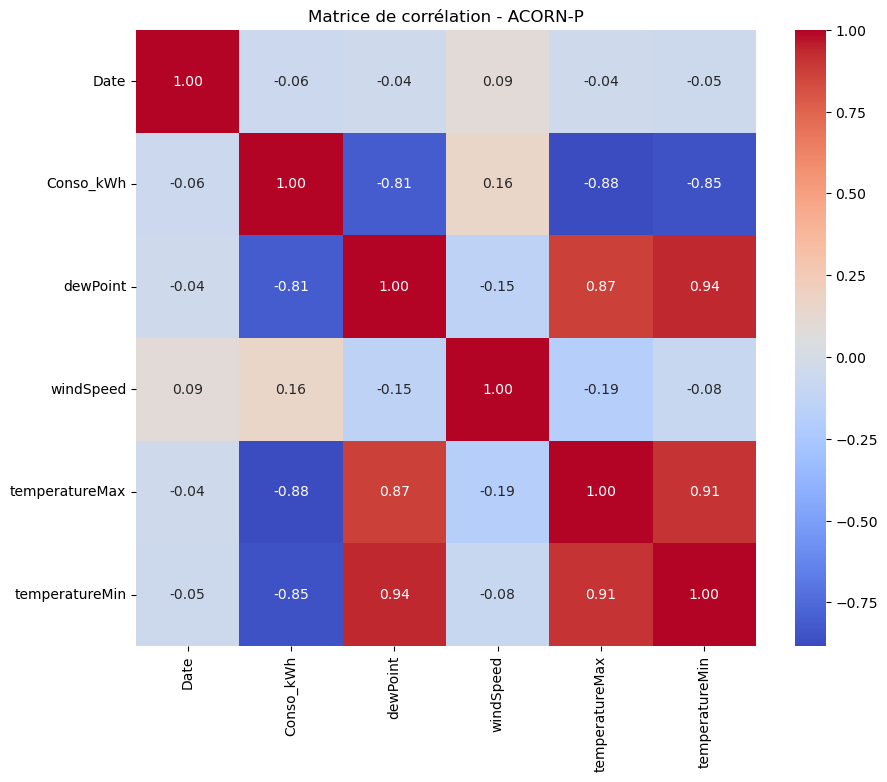

In [39]:
# Affichage des informations et statistiques du dataframe pour chaque Acorn :
for acorn_label, df in zip(['ACORN-C', 'ACORN-F', 'ACORN-P'], [qdfC, qdfF, qdfP]):
    print(f"\n=== Statistiques pour {acorn_label} ===")
    print(df.columns)
    df.info()
    print(df.describe())

    # Histogrammes des variables
    df.hist(bins=30, figsize=(15, 10), edgecolor='black')
    plt.suptitle(f"Histogrammes des variables - {acorn_label}")
    plt.tight_layout()
    plt.show()

    # Matrice de corrélation
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Matrice de corrélation - {acorn_label}")
    plt.show()

In [40]:
# Suppose qdf is your merged dataframe, sorted by Date
qdf = qdf.sort_values('Date')

# Define features and target
X = qdf.drop(columns=['Conso_kWh', 'Date'])  # Drop target and Date
y = qdf['Conso_kWh']

# Time-based split: use the first 70% for training, last 30% for testing
split_idx = int(len(qdf) * 0.7)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

In [ ]:
# Fit of SVC model:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

# Accuracy score :
print("Accuracy (test):", metrics.accuracy_score(y_test, y_test_pred))

ValueError: could not convert string to float: 'ACORN-C'

In [ ]:
parameters = {  'C':[0.01, 1, 5],
                'kernel':('linear', 'rbf'),
                'gamma' :('scale', 'auto')
             }
svc = SVC()

grid_search = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

print("Meilleurs paramètres trouvés :", grid_search.best_params_)
print("Meilleur score (validation croisée) :", grid_search.best_score_)